### Color Encoding

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import networkx as nx

from data.graph_data import *
import ba_utils.visualization as visualization
import ba_utils.orderings as orderings
import ba_utils.color as color

{'t_1905': {'nodes': [{'id': 8, 'name': 'Artist 8', 'num_exhibitions': 3}, {'id': 21, 'name': 'Artist 21', 'num_exhibitions': 2}, {'id': 2, 'name': 'Artist 2', 'num_exhibitions': 4}, {'id': 15, 'name': 'Artist 15', 'num_exhibitions': 6}, {'id': 9, 'name': 'Artist 9', 'num_exhibitions': 2}, {'id': 22, 'name': 'Artist 22', 'num_exhibitions': 2}, {'id': 3, 'name': 'Artist 3', 'num_exhibitions': 4}, {'id': 16, 'name': 'Artist 16', 'num_exhibitions': 7}, {'id': 10, 'name': 'Artist 10', 'num_exhibitions': 3}, {'id': 23, 'name': 'Artist 23', 'num_exhibitions': 2}, {'id': 4, 'name': 'Artist 4', 'num_exhibitions': 3}, {'id': 17, 'name': 'Artist 17', 'num_exhibitions': 6}, {'id': 11, 'name': 'Artist 11', 'num_exhibitions': 6}, {'id': 24, 'name': 'Artist 24', 'num_exhibitions': 1}, {'id': 5, 'name': 'Artist 5', 'num_exhibitions': 3}, {'id': 18, 'name': 'Artist 18', 'num_exhibitions': 3}, {'id': 19, 'name': 'Artist 19', 'num_exhibitions': 2}, {'id': 12, 'name': 'Artist 12', 'num_exhibitions': 6}, 

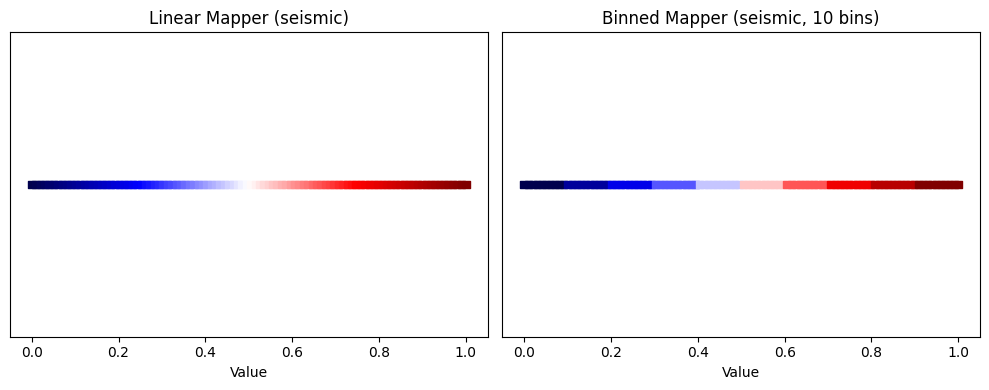

In [2]:
linear_mapper = color.LinearHSVColorMapper(colormap="seismic")
binned_mapper = color.BinnedPercentileColorMapper( colormap="seismic", bins=10)

test_values = np.linspace(0, 1, 10)
bins = 10

test_values = np.linspace(0, 1, 100)

# Prepare the binned values
binned_indices = np.floor(test_values * bins).astype(int)
binned_indices = np.clip(binned_indices, 0, bins - 1)  # Ensure within bounds
binned_values = binned_indices / (bins - 1)

# Linear colors
linear_colors = [linear_mapper.get_color_by_value(value)for value in test_values]

# Binned colors
binned_colors = [binned_mapper.get_color_by_value(value) for value in binned_values]

plt.figure(figsize=(10, 4))

# Linear Mapper Output
plt.subplot(1, 2, 1)
plt.scatter(test_values, [1] * len(test_values), c=linear_colors, s=30, marker='s')
plt.title('Linear Mapper (seismic)')
plt.xlabel('Value')
plt.yticks([])
plt.grid(False)

# Binned Mapper Output
plt.subplot(1, 2, 2)
plt.scatter(test_values, [1] * len(test_values), c=binned_colors, s=30, marker='s')
plt.title('Binned Mapper (seismic, 10 bins)')
plt.xlabel('Value')
plt.yticks([])
plt.grid(False)

plt.tight_layout()
plt.show()

In [3]:
def get_color_by_id(artist_idx, total_artists):
    cmap = plt.colormaps['Greys']  # Greyscale colormap
    norm = mcolors.Normalize(vmin=0, vmax=total_artists - 1)  # Normalization 
    return cmap(norm(artist_idx))

def get_color_by_id2(artist_idx, total_artists):
    cmap = plt.colormaps['bwr']  # Blue-White-Red colormap
    norm = mcolors.Normalize(vmin=0, vmax=total_artists - 1)
    return cmap(norm(artist_idx))

def get_color_by_id3(artist_idx, total_artists):
    #cmap = plt.colormaps['RdYlGn']  # Red-Yellow-Green colormap
    cmap = plt.colormaps['RdYlBu']  # Red-Yellow-Blue colormap
    norm = mcolors.Normalize(vmin=0, vmax=total_artists - 1)
    return cmap(norm(artist_idx))


In [4]:
def normalize(values_dict, min_val=None, max_val=None):
    if max_val == min_val:
        # Handle case where all values are the same
        return {k: 0.5 for k in values_dict}
    return {k: (v - min_val) / (max_val - min_val) for k, v in values_dict.items()}

# this function takes the graph dictionaries {timestamp: Graph, ..} as input, not just json data
def draw_rug_from_graphs(graphs_data, ordering, color_encoding='id', labels=False, pixel_size=40, ax=None):
    centrality_encodings = ['betweenness_centrality', 'degree_centrality', 'closeness_centrality', 'eigenvector_centrality']
    timestamps = sorted(graphs_data.keys())
    num_artists = len(ordering[next(iter(ordering))])
    max_size = 20
    fig_width = min(len(timestamps) * pixel_size / 100, max_size)
    fig_height = min(num_artists * pixel_size / 100, max_size)

    if ax is None:
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
    
    if color_encoding in centrality_encodings or color_encoding == 'degree':
        # Get minimum and maximum across all timestamps
        min_degree_all = num_artists
        max_degree_all = 0
        max_centrality_all = 0
        min_centrality_all = 1
        centralities = {}
        normalized_centralities = {}
        
        for timestamp in timestamps:
            G = graphs_data[timestamp]
            degrees = dict(G.degree())
            if color_encoding == 'betweenness_centrality':
                centralities[timestamp] = nx.betweenness_centrality(G, weight='weight')
            elif color_encoding == 'degree_centrality':
                centralities[timestamp] = nx.degree_centrality(G)
            elif color_encoding == 'closeness_centrality':
                centralities[timestamp] = nx.closeness_centrality(G)
            elif color_encoding == 'eigenvector_centrality':
                centralities[timestamp] = nx.eigenvector_centrality(G, max_iter=10000, tol=1e-6, weight='weight')
            
            if color_encoding != 'degree':
                min_centrality_all = min(min_centrality_all, min(centralities[timestamp].values()))
                max_centrality_all = max(max_centrality_all, max(centralities[timestamp].values()))
                
            else:
                max_degree_all = max(max_degree_all, max(degrees.values()))
                min_degree_all = min(min_degree_all, min(degrees.values()))
        
        #TODO: Add function to color by the number of exhibitions
        
    for t_idx, timestamp in enumerate(timestamps):
        G = graphs_data[timestamp]
        node_order = ordering[timestamp]
        
        if color_encoding in centrality_encodings:
            normalized_centralities[timestamp] = normalize(centralities[timestamp], min_centrality_all, max_centrality_all)
        
        for y_idx, artist_id in enumerate(node_order):
            
            if color_encoding == 'id':
                color = get_color_by_id(artist_id, num_artists)
            elif color_encoding == 'id2':
                color = get_color_by_id2(artist_id, num_artists)
            elif color_encoding == 'id3':
                color = get_color_by_id3(artist_id, num_artists)
            elif color_encoding == 'betweenness_centrality':
                color = binned_mapper.get_color_by_value(normalized_centralities[timestamp][artist_id])
            elif color_encoding == 'degree_centrality':
                color = binned_mapper.get_color_by_value(normalized_centralities[timestamp][artist_id])
            elif color_encoding == 'closeness_centrality':
                color = binned_mapper.get_color_by_value(normalized_centralities[timestamp][artist_id])
            elif color_encoding == 'eigenvector_centrality':
                color = binned_mapper.get_color_by_value(normalized_centralities[timestamp][artist_id])
            elif color_encoding == 'degree':
                color = binned_mapper.get_color_by_value(normalize({artist_id: G.degree(artist_id)}, min_degree_all, max_degree_all)[artist_id])
                
            # matplotlib rectangle
            x_start = t_idx * pixel_size
            y_start = y_idx * pixel_size
            rect = plt.Rectangle(
                (x_start, y_start), pixel_size, pixel_size, color=color
            )
            ax.add_patch(rect)

            if labels:
                ax.text(
                    x_start + pixel_size / 2, 
                    y_start + pixel_size / 2, 
                    str(artist_id), 
                    color='white', 
                    ha='center', 
                    va='center',
                    fontsize=15
                )

    ax.set_xlim(0, len(timestamps) * pixel_size)
    ax.set_ylim(0, num_artists * pixel_size)
    ax.set_xticks([pixel_size * i + pixel_size / 2 for i in range(len(timestamps))])
    ax.set_xticklabels(timestamps, rotation=45)
    ax.set_yticks([])
    ax.set_yticklabels([])
    ax.invert_yaxis()  # invert y-axis to have the first artist at the top
    ax.axis('off')

    # Only return the figure if a new one was created
    if ax is None:
        plt.show()
    return fig if ax is None else None


Graphs received: {'t_1905': <networkx.classes.graph.Graph object at 0x0000022B58C85BB0>, 't_1906': <networkx.classes.graph.Graph object at 0x0000022B58C85C10>, 't_1907': <networkx.classes.graph.Graph object at 0x0000022B58C85BE0>, 't_1908': <networkx.classes.graph.Graph object at 0x0000022B58C85C40>, 't_1909': <networkx.classes.graph.Graph object at 0x0000022B58C85C70>, 't_1910': <networkx.classes.graph.Graph object at 0x0000022B58C85CD0>, 't_1911': <networkx.classes.graph.Graph object at 0x0000022B58C85CA0>, 't_1912': <networkx.classes.graph.Graph object at 0x0000022B58C85D30>, 't_1913': <networkx.classes.graph.Graph object at 0x0000022B58C85D00>, 't_1914': <networkx.classes.graph.Graph object at 0x0000022B58C85D60>, 't_1915': <networkx.classes.graph.Graph object at 0x0000022B58C85D90>}


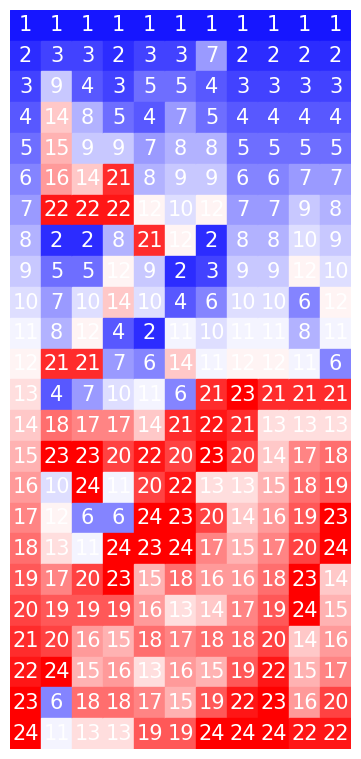

In [5]:
ordering = orderings.get_BFS_ordering(split2_graphs, sorting_key="common_neighbors")
fig = draw_rug_from_graphs(split2_graphs, ordering, color_encoding='id2', labels=True, pixel_size=40)
plt.show()

Graphs received: {'t_1904': <networkx.classes.graph.Graph object at 0x0000025BFB949100>, 't_1905': <networkx.classes.graph.Graph object at 0x0000025BFB949130>, 't_1906': <networkx.classes.graph.Graph object at 0x0000025BFB9491C0>, 't_1907': <networkx.classes.graph.Graph object at 0x0000025BFB949220>, 't_1908': <networkx.classes.graph.Graph object at 0x0000025BFB949280>, 't_1909': <networkx.classes.graph.Graph object at 0x0000025BFB9492E0>, 't_1910': <networkx.classes.graph.Graph object at 0x0000025BFB949340>, 't_1911': <networkx.classes.graph.Graph object at 0x0000025BFB9493D0>, 't_1912': <networkx.classes.graph.Graph object at 0x0000025BFB949400>, 't_1913': <networkx.classes.graph.Graph object at 0x0000025BFB949460>, 't_1914': <networkx.classes.graph.Graph object at 0x0000025BFB9494C0>}


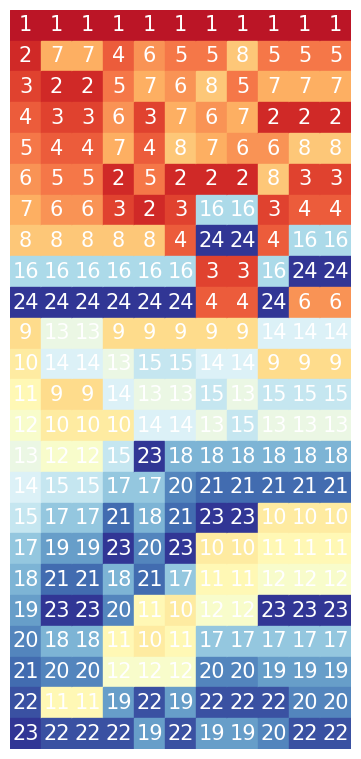

In [26]:
ordering = orderings.get_BFS_ordering(three_groups_graphs, sorting_key="common_neighbors")
fig = draw_rug_from_graphs(three_groups_graphs, ordering, color_encoding='id3', labels=True, pixel_size=40)
plt.show()

Graphs received: {'t_1905': <networkx.classes.graph.Graph object at 0x0000025BFB565FA0>, 't_1906': <networkx.classes.graph.Graph object at 0x0000025BFB566000>, 't_1907': <networkx.classes.graph.Graph object at 0x0000025BFB565FD0>, 't_1908': <networkx.classes.graph.Graph object at 0x0000025BFB566030>, 't_1909': <networkx.classes.graph.Graph object at 0x0000025BFB566060>, 't_1910': <networkx.classes.graph.Graph object at 0x0000025BFB5660C0>, 't_1911': <networkx.classes.graph.Graph object at 0x0000025BFB566090>, 't_1912': <networkx.classes.graph.Graph object at 0x0000025BFB566120>, 't_1913': <networkx.classes.graph.Graph object at 0x0000025BFB5660F0>, 't_1914': <networkx.classes.graph.Graph object at 0x0000025BFB566150>, 't_1915': <networkx.classes.graph.Graph object at 0x0000025BFB566180>}


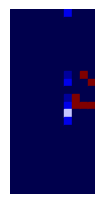

In [ ]:
ordering = orderings.get_BFS_ordering(split2_graphs, sorting_key="common_neighbors")
fig = draw_rug_from_graphs(split2_graphs, ordering, color_encoding='betweenness_centrality', pixel_size=10)
plt.show()

Graphs received: {'t_1905': <networkx.classes.graph.Graph object at 0x0000025BFB566510>, 't_1906': <networkx.classes.graph.Graph object at 0x0000025BFB566570>, 't_1907': <networkx.classes.graph.Graph object at 0x0000025BFB566540>, 't_1908': <networkx.classes.graph.Graph object at 0x0000025BFB5665A0>, 't_1909': <networkx.classes.graph.Graph object at 0x0000025BFB5665D0>, 't_1910': <networkx.classes.graph.Graph object at 0x0000025BFB566660>, 't_1911': <networkx.classes.graph.Graph object at 0x0000025BFB566690>, 't_1912': <networkx.classes.graph.Graph object at 0x0000025BFB5666F0>, 't_1913': <networkx.classes.graph.Graph object at 0x0000025BFB566780>, 't_1914': <networkx.classes.graph.Graph object at 0x0000025BFB5667B0>, 't_1915': <networkx.classes.graph.Graph object at 0x0000025BFB566810>}


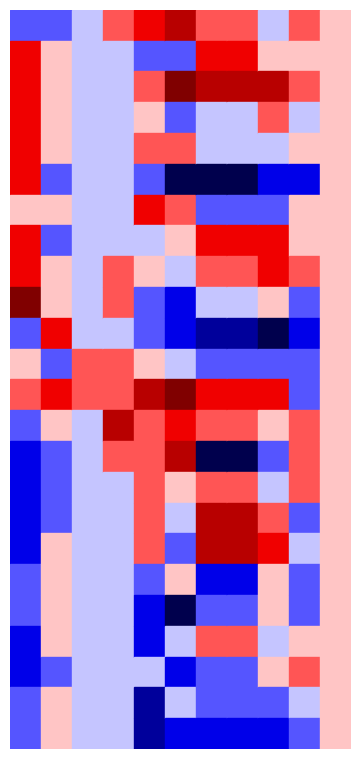

In [19]:
ordering = orderings.get_BFS_ordering(merge_graphs)
fig = draw_rug_from_graphs(merge_graphs, ordering, color_encoding='eigenvector_centrality', pixel_size=40)
plt.show()

Graphs received: {'t_1905': <networkx.classes.graph.Graph object at 0x000001422B2D1FA0>, 't_1906': <networkx.classes.graph.Graph object at 0x000001422B2D2000>, 't_1907': <networkx.classes.graph.Graph object at 0x000001422B2D1FD0>, 't_1908': <networkx.classes.graph.Graph object at 0x000001422B2D2030>, 't_1909': <networkx.classes.graph.Graph object at 0x000001422B2D2060>, 't_1910': <networkx.classes.graph.Graph object at 0x000001422B2D20F0>, 't_1911': <networkx.classes.graph.Graph object at 0x000001422B2D2120>, 't_1912': <networkx.classes.graph.Graph object at 0x000001422B2D2180>, 't_1913': <networkx.classes.graph.Graph object at 0x000001422B2D2210>, 't_1914': <networkx.classes.graph.Graph object at 0x000001422B2D2240>, 't_1915': <networkx.classes.graph.Graph object at 0x000001422B2D22A0>}
Minimum centrality over all timestamps: 0.4791666666666667
Maximum centrality over all timestamps: 1.0
Maximum degree over all timestamps: 0
Centralities: {'t_1905': {14: 0.48936170212765956, 1: 0.4791

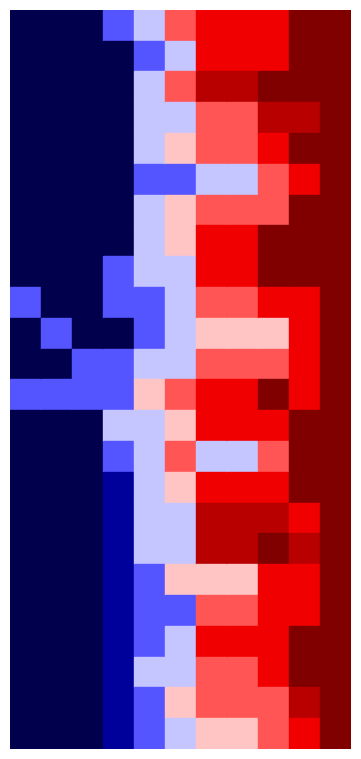

In [10]:
ordering = orderings.get_BFS_ordering(merge_graphs)
fig = draw_rug_from_graphs(merge_graphs, ordering, color_encoding='closeness_centrality', pixel_size=40)
plt.show()

In [47]:
def draw_all_colored(graphs, title="", save=False, color_encoding='degree_centrality', labels=False):
    fig, axes = plt.subplots(1, 7, figsize=(20, 6))

    bfs_ordering = orderings.get_BFS_ordering(graphs, sorting_key='weight')
    draw_rug_from_graphs(graphs, bfs_ordering, ax=axes[0], color_encoding=color_encoding, labels=labels)
    axes[0].set_title("BFS: Weight")

    bfs_ordering = orderings.get_BFS_ordering(graphs, sorting_key='common_neighbors')
    draw_rug_from_graphs(graphs, bfs_ordering, ax=axes[1], color_encoding=color_encoding, labels=labels)
    axes[1].set_title("BFS: Common Neighbors")
    
    bfs_ordering = orderings.get_BFS_ordering(graphs, sorting_key='id')
    draw_rug_from_graphs(graphs, bfs_ordering, ax=axes[2], color_encoding=color_encoding, labels=labels)
    axes[2].set_title("BFS: ID")
    
    #bfs_ordering = orderings.get_BFS_ordering(graphs, sorting_key='weight_desID')
    #draw_plot_from_graphs(graphs, bfs_ordering, ax=axes[2])
    #axes[2].set_title("BFS:Weight_descending ID")
    
    priority_ordering = orderings.get_priority_bfs_ordering(graphs)
    draw_rug_from_graphs(graphs, priority_ordering, ax=axes[3], color_encoding=color_encoding, labels=labels)
    axes[3].set_title("Priority")

    neighborhoods_ordering = orderings.get_community_ordering(graphs, "closeness")
    draw_rug_from_graphs(graphs, neighborhoods_ordering, ax=axes[4], color_encoding=color_encoding, labels=labels)
    axes[4].set_title("Community")
    
    #dfs_ordering = orderings.get_DFS_ordering(graphs)
    #visualization.draw_rug_plot_with_ids(graphs, dfs_ordering, ax=axes[4])
    #axes[4].set_title("DFS")
    
    degree_ordering = orderings.get_degree_ordering(graphs)
    draw_rug_from_graphs(graphs, degree_ordering, ax=axes[5], color_encoding=color_encoding, labels=labels)
    axes[5].set_title("Degree")
    
    centrality_ordering = orderings.get_centrality_ordering(graphs, centrality_measure='eigenvector')
    draw_rug_from_graphs(graphs, centrality_ordering, ax=axes[6], color_encoding=color_encoding, labels=labels)
    axes[6].set_title("Centrality: Eigenvector")

    if title != "":
        title = f"Ordering Comparison for {title}, Color Encoding: {color_encoding}"
        plt.figtext(0.5, -0.05, title, ha="center", fontsize=12)
    plt.tight_layout()
    
    if save:
        fig.savefig(f"{title}.png")
    
    return fig

Graphs received: {'t_1905': <networkx.classes.graph.Graph object at 0x000001422B2D1FA0>, 't_1906': <networkx.classes.graph.Graph object at 0x000001422B2D2000>, 't_1907': <networkx.classes.graph.Graph object at 0x000001422B2D1FD0>, 't_1908': <networkx.classes.graph.Graph object at 0x000001422B2D2030>, 't_1909': <networkx.classes.graph.Graph object at 0x000001422B2D2060>, 't_1910': <networkx.classes.graph.Graph object at 0x000001422B2D20F0>, 't_1911': <networkx.classes.graph.Graph object at 0x000001422B2D2120>, 't_1912': <networkx.classes.graph.Graph object at 0x000001422B2D2180>, 't_1913': <networkx.classes.graph.Graph object at 0x000001422B2D2210>, 't_1914': <networkx.classes.graph.Graph object at 0x000001422B2D2240>, 't_1915': <networkx.classes.graph.Graph object at 0x000001422B2D22A0>}
Minimum centrality over all timestamps: 0.3913043478260869
Maximum centrality over all timestamps: 1.0
Maximum degree over all timestamps: 0
Centralities: {'t_1905': {14: 0.43478260869565216, 1: 0.3913

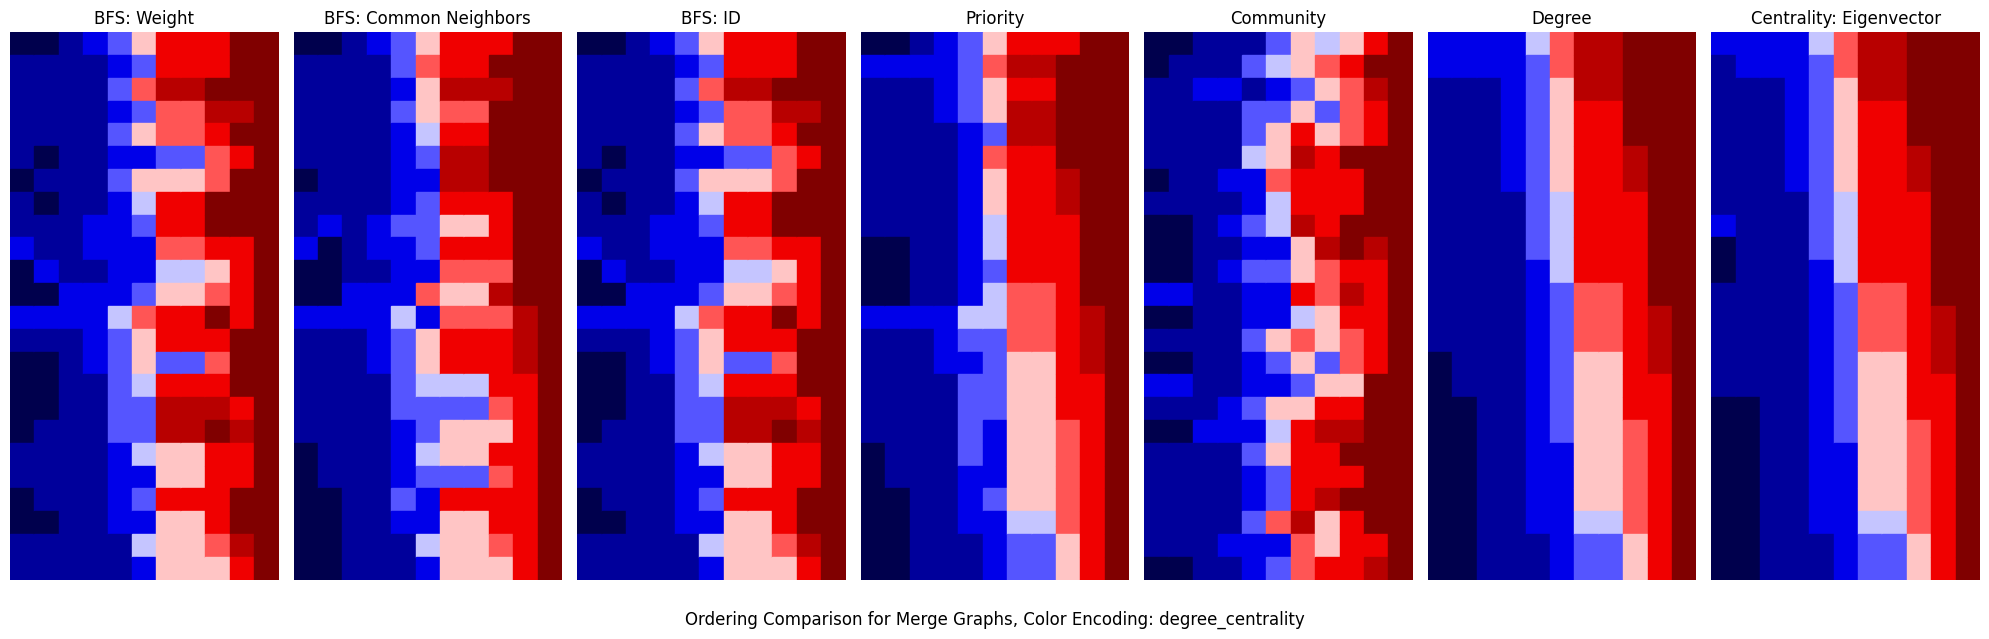

In [48]:
fig = draw_all_colored(merge_graphs, title="Merge Graphs", save=True, color_encoding='degree_centrality', labels=False)

In [12]:
for timestamp, G in merge_graphs.items():
    print("Timestamp:", timestamp)
    sorted_nodes = sorted(G.nodes(data=True), key=lambda x: G.degree(x[0]), reverse=True)
    for node, data in sorted_nodes:
        print(f"Node {node}: degree = {G.degree(node)}")

Timestamp: t_1905
Node 12: degree = 12
Node 21: degree = 12
Node 7: degree = 11
Node 13: degree = 11
Node 19: degree = 11
Node 18: degree = 11
Node 5: degree = 11
Node 24: degree = 11
Node 4: degree = 11
Node 23: degree = 11
Node 10: degree = 11
Node 3: degree = 11
Node 9: degree = 11
Node 2: degree = 11
Node 14: degree = 10
Node 20: degree = 10
Node 11: degree = 10
Node 17: degree = 10
Node 16: degree = 10
Node 22: degree = 10
Node 15: degree = 10
Node 8: degree = 10
Node 1: degree = 9
Node 6: degree = 9
Timestamp: t_1906
Node 12: degree = 12
Node 21: degree = 12
Node 20: degree = 11
Node 7: degree = 11
Node 13: degree = 11
Node 19: degree = 11
Node 18: degree = 11
Node 5: degree = 11
Node 24: degree = 11
Node 17: degree = 11
Node 4: degree = 11
Node 23: degree = 11
Node 10: degree = 11
Node 3: degree = 11
Node 9: degree = 11
Node 2: degree = 11
Node 14: degree = 10
Node 1: degree = 10
Node 6: degree = 10
Node 11: degree = 10
Node 16: degree = 10
Node 22: degree = 10
Node 15: degree =

In [20]:
max_exhibitions = 0
for node, data in G.nodes(data=True):
    num_exhibitions = data.get('num_exhibitions', 0)
    #print(f"Node {node}: num_exhibitions = {num_exhibitions}")
    if num_exhibitions > max_exhibitions:
        max_exhibitions = num_exhibitions

print(f"Max num_exhibitions: {max_exhibitions}")

Max num_exhibitions: 9
